In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from scipy.optimize import minimize

El objetivo de esta hoja es la descripcion de los Datos utilizados en las siguientes aplicaciones.

Data for USA:

(1) : Real Gross Domestic Producthttps, Billions of Chained 2017 Dollars,
Seasonally Adjusted Annual Rate, Quarterly : https://fred.stlouisfed.org/series/GDPC1

(2) Industrial Production Index 2017=100, Seasonally Adjusted, Monthly:
https://fred.stlouisfed.org/series/INDPRO

(3) Real personal income excluding current transfer receipts, Billions of Chained 2017 Dollars,Seasonally Adjusted Annual Rate, Monthly:
https://fred.stlouisfed.org/series/W875RX1

(4) Real Manufacturing and Trade Industries Sales, Millions of Chained 2017 Dollars,Seasonally Adjusted, Monthly:
https://fred.stlouisfed.org/series/CMRMTSPL

(5) All Employees: Total Nonfarm Payrolls, Thousands of Persons, Monthly, Seasonally Adjusted:
https://fred.stlouisfed.org/series/PAYEMS



(1) --> Economy Indicator (RGDP)

(2) --> Supply

(3) --> Income

(4) --> Demand

(5) --> Employment


Estos datos en crudo seran transformados a 1º Diferencias (first-differences) y Standarizaremos.

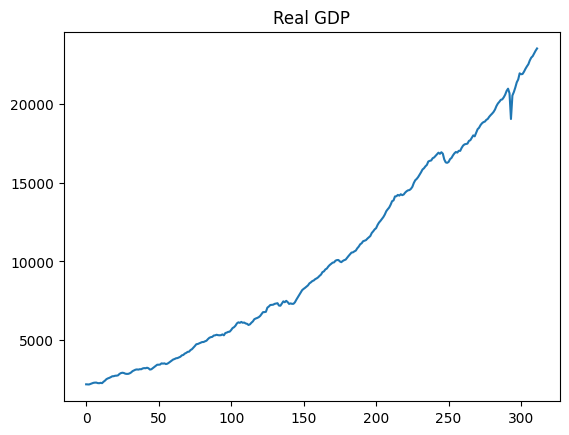

In [ ]:
# (0):
RGDP = pd.read_csv("GDPC1.csv")
# Plot
plt.plot( RGDP['GDPC1'])
plt.title("Real GDP")
plt.show()

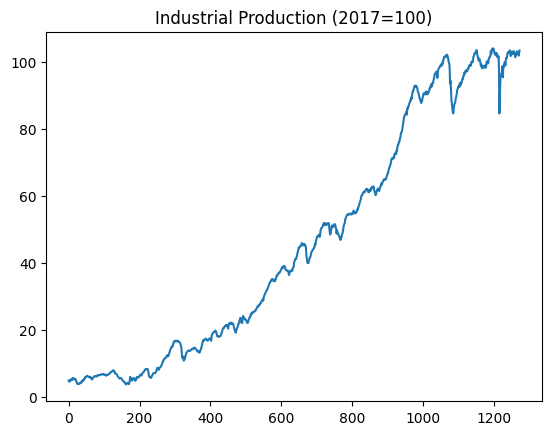

In [ ]:
# (1):
IP = pd.read_csv("IP_USA.csv")
# Plot
plt.plot( IP['INDPRO'])
plt.title("Industrial Production (2017=100)")
plt.show()

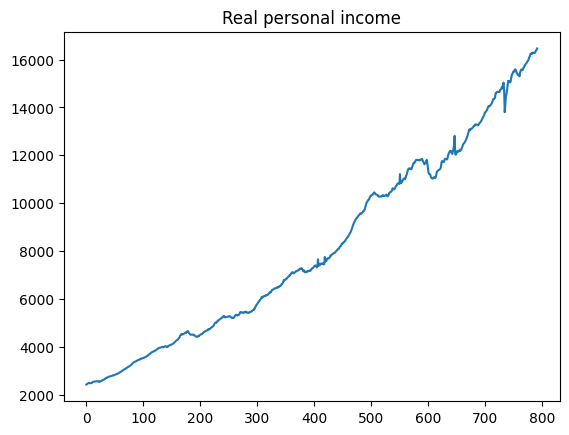

In [ ]:
# (2):
Income = pd.read_csv("Income_USA.csv")
# Plot
plt.plot( Income['W875RX1'])
plt.title("Real personal income")
plt.show()

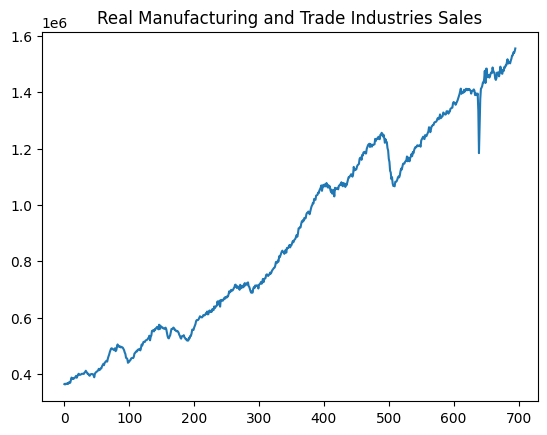

In [ ]:
# (3):
Trade = pd.read_csv("Trade_USA.csv")
# Plot
plt.plot( Trade['CMRMTSPL'])
plt.title("Real Manufacturing and Trade Industries Sales")
plt.show()

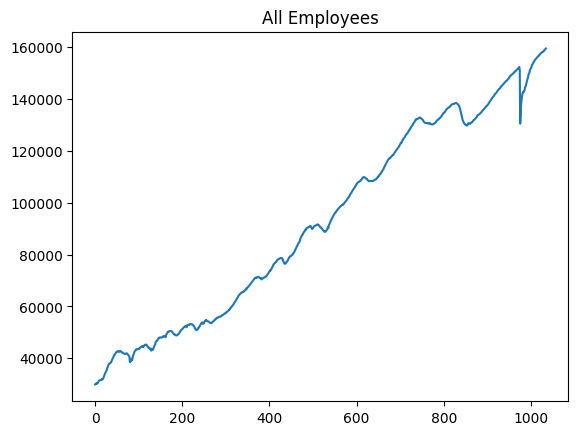

In [ ]:
# (4):
Employ = pd.read_csv("PAYEMS.csv")
# Plot
plt.plot( Employ['PAYEMS'])
plt.title("All Employees")
plt.show()

## 1) First Differences

In [ ]:
RGDP_v = pd.read_csv("GDPC1.csv")
RGDP_v.set_index('observation_date')
RGDP_v['observation_date'] = pd.to_datetime(RGDP_v['observation_date'])
RGDP_v = RGDP_v.set_index('observation_date')

RGDP = pd.read_csv("GDPC1.csv")
RGDP['observation_date'] = pd.to_datetime(RGDP['observation_date'])
RGDP = RGDP.set_index('observation_date').resample('M').asfreq()  # resample a mensual con NaN en los huecos



# Recorremos los índices del df corto (trimestral)
for fecha in RGDP_v.index:
    mask = (RGDP.index.year == fecha.year) & (RGDP.index.month == fecha.month)
    RGDP.loc[mask, 'GDPC1'] = RGDP_v.loc[fecha, 'GDPC1']

<ipython-input-7-82917ba88ce0>:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  RGDP = RGDP.set_index('observation_date').resample('M').asfreq()  # resample a mensual con NaN en los huecos


In [ ]:
RGDP = RGDP.reset_index()
# Asegúrate de que la columna es de tipo datetime
RGDP['observation_date'] = pd.to_datetime(RGDP['observation_date'])
# Ajusta todas las fechas para que el día sea '01'
RGDP['observation_date'] = RGDP['observation_date'].dt.to_period('M').dt.to_timestamp()

In [ ]:
# Set date data type:
IP['observation_date'] = pd.to_datetime(IP['observation_date'])
Income['observation_date'] = pd.to_datetime(Income['observation_date'])
Trade['observation_date'] = pd.to_datetime(Trade['observation_date'])
Employ['observation_date'] = pd.to_datetime(Employ['observation_date'])
# Calcular los cambios porcentuales
RGDP['RGDP_change'] = RGDP['GDPC1'].pct_change(periods=3)
IP['Value'] = IP['INDPRO'].pct_change()
Income['Value'] = Income['W875RX1'].pct_change()
Trade['Value'] = Trade['CMRMTSPL'].pct_change()
Employ['Value'] = Employ['PAYEMS'].pct_change()

# Merge de todas las series mensuales
Data_ = IP[['observation_date', 'Value']].merge(
    Income[['observation_date','Value']], on='observation_date', how='outer', suffixes=('_IP', '_Income')
).merge(
    Trade[['observation_date','Value']], on='observation_date', how='outer', suffixes=('_Income', '_Trade')
).merge(
    Employ[['observation_date','Value']], on='observation_date', how='outer', suffixes=('_Trade', '_Employ')
)

Data_ = Data_.rename(columns={
    'observation_date': 'date',
    'Value_IP': 'IP',
    'Value_Income': 'Income',
    'Value_Trade': 'Trade',
    'Value_Employ': 'Employ'
})

# Merge con el GDP trimestral ya resampleado a mensual (con NaNs en meses no disponibles)
Data = Data_.merge(RGDP, left_on='date', right_on='observation_date', how='left').drop(columns=['observation_date','GDPC1'])

# let only quaterly:
# Filtramos la columna 'RGDP_change' solo para los meses 1, 4, 7 y 10
Data['RGDP_change'] = Data.apply(
    lambda row: row['RGDP_change'] if row['date'].month in [1, 4, 7, 10] else None, axis=1
)
Data = Data.rename(columns={
    'observation_date': 'date',
    'Value_IP': 'IP',
    'Value_Income': 'Income',
    'Value_Trade': 'Trade',
    'Value_Employ': 'Employ',
    'RGDP_change': 'RGDP'
})

# Mover 'RGDP_change' al segundo puesto
cols = [Data.columns[0], 'RGDP'] + [col for col in Data.columns if col not in ['RGDP', Data.columns[0]]]
Data = Data[cols]

# ✅ Resultado final
print(Data.tail(12))

           date      RGDP        IP    Income     Trade    Employ
1263 2024-04-01  0.007390 -0.001578 -0.001789 -0.002467  0.000749
1264 2024-05-01       NaN  0.006086  0.003159  0.006197  0.001224
1265 2024-06-01       NaN  0.002658  0.000025  0.004782  0.000551
1266 2024-07-01  0.007595 -0.007111 -0.000675  0.007188  0.000557
1267 2024-08-01       NaN  0.004881 -0.000117  0.000375  0.000449
1268 2024-09-01       NaN -0.004196  0.000240  0.007180  0.001518
1269 2024-10-01  0.006071 -0.004537  0.003494 -0.001712  0.000278
1270 2024-11-01       NaN -0.001452  0.002760  0.004001  0.001648
1271 2024-12-01       NaN  0.009902  0.001392  0.006688  0.002036
1272 2025-01-01       NaN  0.005124  0.003462       NaN  0.000698
1273 2025-02-01       NaN       NaN       NaN       NaN  0.000736
1274 2025-03-01       NaN       NaN       NaN       NaN  0.001432


<ipython-input-9-0f71fbfdf2f0>:7: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  RGDP['RGDP_change'] = RGDP['GDPC1'].pct_change(periods=3)


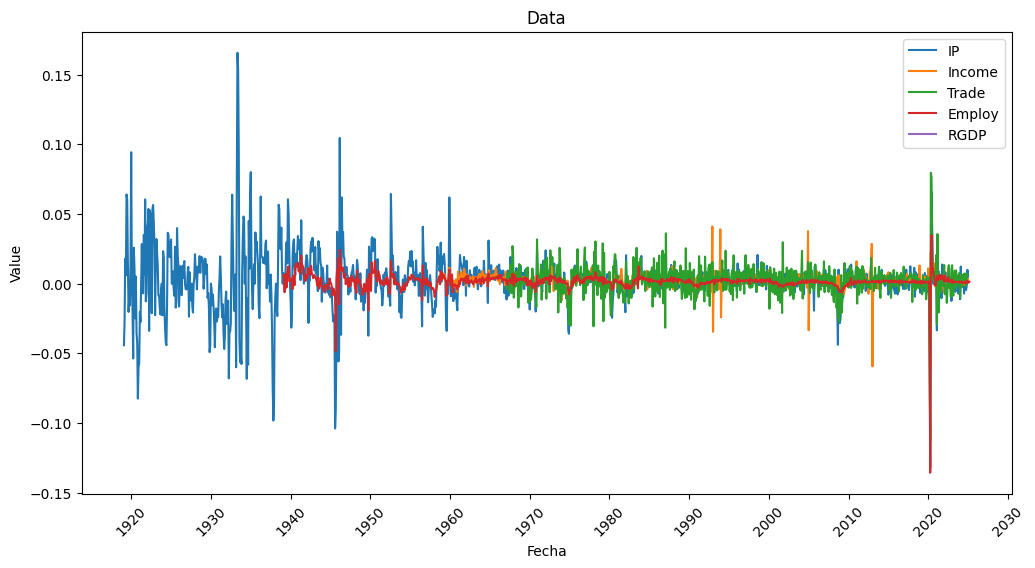

In [ ]:
# Plotamos nueva data:

fig, ax = plt.subplots(figsize=(12, 6))
# Ploteamos las series
ax.plot( Data['date'],Data['IP'],label="IP")
ax.plot( Data['date'],Data['Income'],label="Income")
ax.plot( Data['date'],Data['Trade'], label="Trade")
ax.plot( Data['date'],Data['Employ'], label="Employ")
ax.plot( Data['date'],Data['RGDP'], label="RGDP")


# Formatear el eje X para mostrar solo una fecha cada 12 meses
ax.xaxis.set_major_locator(mdates.YearLocator(base=10))  # Cada año
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Mostrar solo el año


# Rotamos las etiquetas del eje X para mejor legibilidad
plt.xticks(rotation=45)

# Añadimos título y leyenda
plt.title('Data')
plt.xlabel('Fecha')
plt.ylabel('Value')
plt.legend()

# Mostramos el gráfico
plt.show()

We take off periods before 1970 (great moderation (?)):

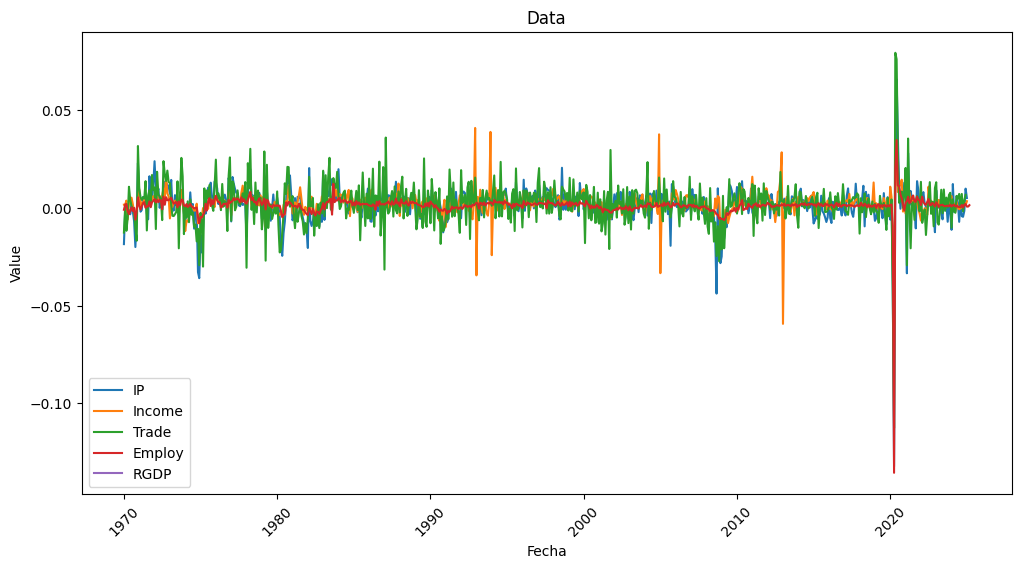

In [ ]:
# Let's start the DB at 1970 where it seems three columns are full:
# Also GREAT MODERATION no??
Data = Data[Data['date'] >= '1970-01-01']


# Plotamos nueva data:

fig, ax = plt.subplots(figsize=(12, 6))
# Ploteamos las series
ax.plot( Data['date'],Data['IP'],label="IP")
ax.plot( Data['date'],Data['Income'],label="Income")
ax.plot( Data['date'],Data['Trade'], label="Trade")
ax.plot( Data['date'],Data['Employ'], label="Employ")
ax.plot( Data['date'],Data['RGDP'], label="RGDP")


# Formatear el eje X para mostrar solo una fecha cada 12 meses
ax.xaxis.set_major_locator(mdates.YearLocator(base=10))  # Cada año
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Mostrar solo el año


# Rotamos las etiquetas del eje X para mejor legibilidad
plt.xticks(rotation=45)

# Añadimos título y leyenda
plt.title('Data')
plt.xlabel('Fecha')
plt.ylabel('Value')
plt.legend()

# Mostramos el gráfico
plt.show()

## 2) Standarize Data

In [ ]:
data = Data[['RGDP','IP', 'Income', 'Trade','Employ']]

# Normalizar cada columna
data_n = (data - data.mean()) / data.std()
T,n = data_n.shape

In [ ]:
data

,RGDP,IP,Income,Trade,Employ
612,-0.001489,-0.018518,0.001686,-0.012604,-0.000912
613,NaN,-0.000659,0.001759,0.000889,0.001812
614,NaN,-0.001298,0.003788,-0.011685,0.002048
615,0.001417,-0.002570,-0.005898,-0.005054,-0.001442
616,NaN,-0.001165,0.002112,0.010861,-0.003140
...,...,...,...,...,...
1270,NaN,-0.001452,0.002760,0.004001,0.001648
1271,NaN,0.009902,0.001392,0.006688,0.002036
1272,NaN,0.005124,0.003462,NaN,0.000698
1273,NaN,NaN,NaN,NaN,0.000736


## 3) Save resulting Data

In [ ]:
# Guardamos La BD Data en un archovo .csv:
data_n.to_csv('USA_Normalize_Data.csv', index=False, encoding='utf-8')

## Recession Periods:

NBER based Recession Indicators for the United States from the Period following the Peak through the Trough:
https://fred.stlouisfed.org/series/USREC

In [ ]:
NBER.columns

Index(['observation_date', 'USREC'], dtype='object')

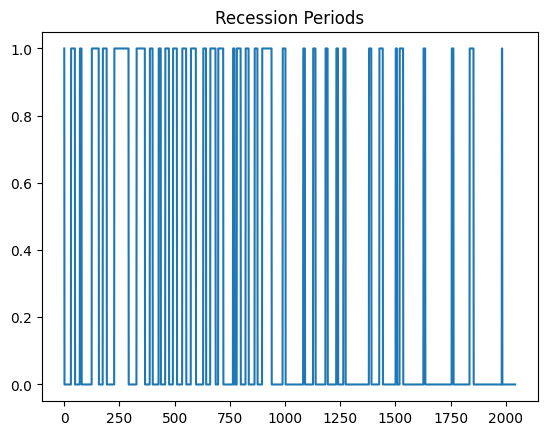

In [ ]:
# (5):
NBER = pd.read_csv("USREC.csv")
# Plot
plt.plot( NBER['USREC'])
plt.title("Recession Periods")
plt.show()

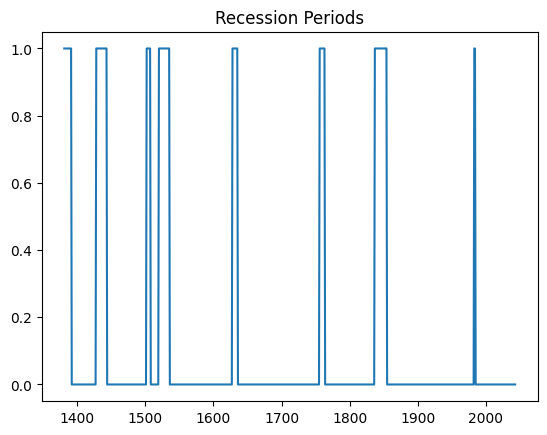

In [ ]:
# same but for periods elicitation:

# Pasamos a formato date la columna de fechas:
NBER['observation_date'] = pd.to_datetime(NBER['observation_date'])

# Let's start the DB at 1970 where it seems three columns are full:
# Also GREAT MODERATION no??
NBER_ = NBER[NBER['observation_date'] >= '1970-01-01']

# Plot
plt.plot( NBER_['USREC'])
plt.title("Recession Periods")
plt.show()

# Guardamos La BD Data en un archovo .csv:

NBER_.to_csv('USA_Recession_Data.csv', index=False, encoding='utf-8')